In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
livetime = 48 * u.h
n_obs = 100
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
model = [] 
mod = SkyModel(spectral_model=model_simu)
model.append(mod)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [6]:
l = [0.01,0.1,0.2,0.3,0.5,1,2,3,5]
simu = []
for i in range(9):
    sim = ExpCutoffPowerLawSpectralModel(
        index=2.22,
        amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=l[i] * u.Unit("TeV-1"),
        alpha = 1,
    )
    mod = SkyModel(spectral_model=sim)
    simu.append(sim)
    model.append(mod)
    print(model[i+1])
    print(simu[i])

SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  Fa

In [7]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [9]:
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
data = []
for i in range(len(model)):
    dataset.model = model[i]
    dataset.fake(random_state=42)
    print(dataset)
    data.append(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit 

In [11]:
data_onoff = []
for i in range(len(model)):
    dataset_onoff = SpectrumDatasetOnOff(
        aeff=dataset.aeff,
        edisp=dataset.edisp,
        models=model[i],
        livetime=livetime,
        acceptance=1,
        acceptance_off=5,
    )
    dataset_onoff.fake(background_model=dataset.background)
    print(dataset_onoff)
    data_onoff.append(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36940 
    Total predicted counts          : 37348.74
    Total off counts                : 102114.00

    Total background counts         : 20422.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36989 
    Total predicted counts          : 37064.54
    Total off counts                : 101777.00

    Total background counts         : 20355.40

 

In [12]:
%%time
datas = []
for i in range(len(model)):
    datasets = []
    for idx in range(n_obs):
        data_onoff[i].fake(random_state=idx, background_model=dataset.background)
        data_onoff[i].name = f"obs_{idx}"
        datasets.append(data_onoff[i].copy())
    datas.append(datasets)

CPU times: user 3.78 s, sys: 32.5 ms, total: 3.81 s
Wall time: 3.81 s


In [13]:
len(datas)
print(*datas[0], sep = "\n")

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37107 
    Total predicted counts          : 37257.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36990 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 37397 
    Total predicted counts          : 37253.94
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 37115 
    Total predicted counts          : 37293.94
    Total off counts                : 101840.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_46 

    Total counts                    : 36803 
    Total predicted counts          : 37030.14
    Total off counts                : 100521.00

    Total background counts         : 20104.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 37596 
    Total predicted counts          : 37184.54
    Total off counts                : 101293.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_69 

    Total counts                    : 37025 
    Total predicted counts          : 37134.34
    Total off counts                : 101042.00

    Total background counts         : 20208.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_70 

    Total counts                    : 37245 
    Total predicted counts          : 37231.74
    Total off counts                : 101529.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_99 

    Total counts                    : 37397 
    Total predicted counts          : 37283.94
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.48

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



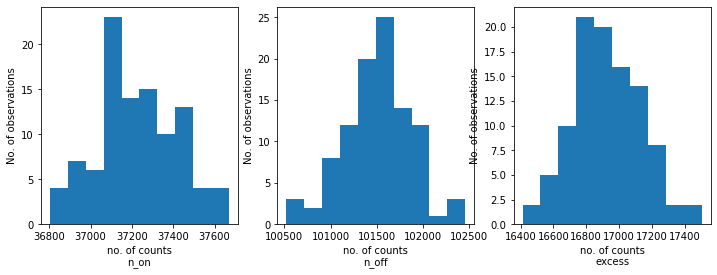

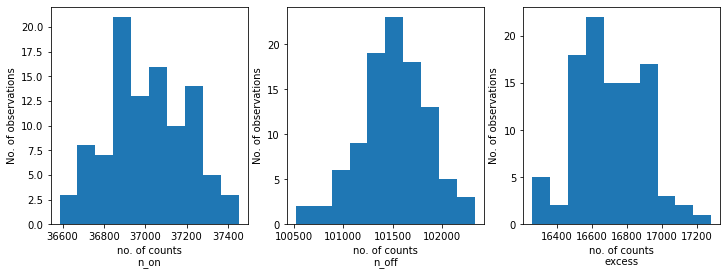

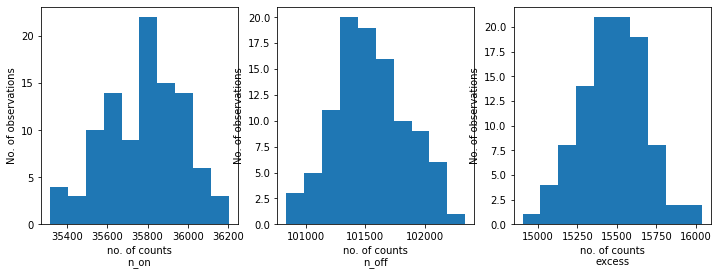

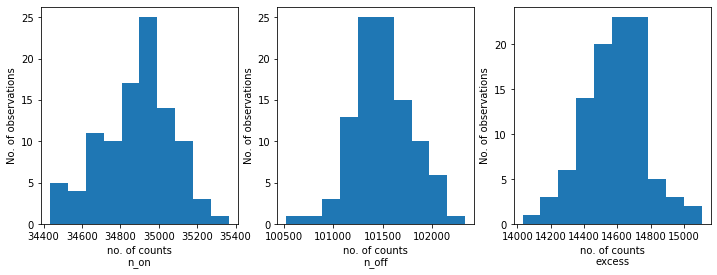

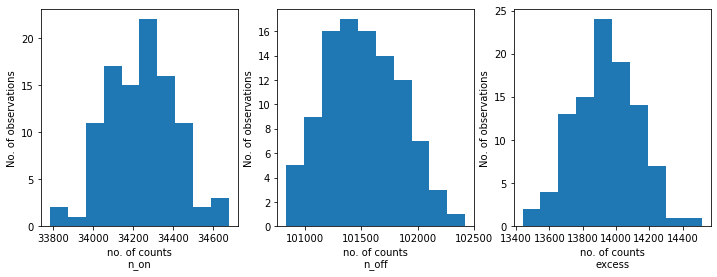

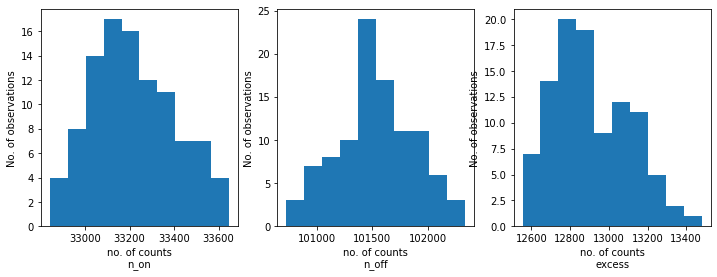

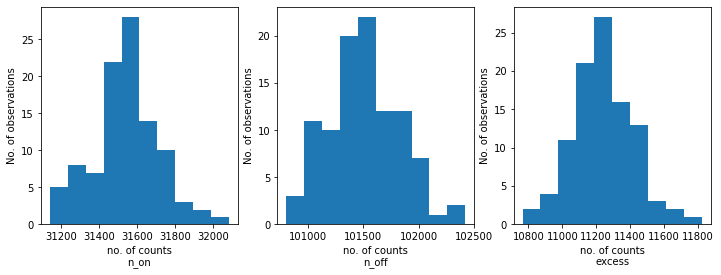

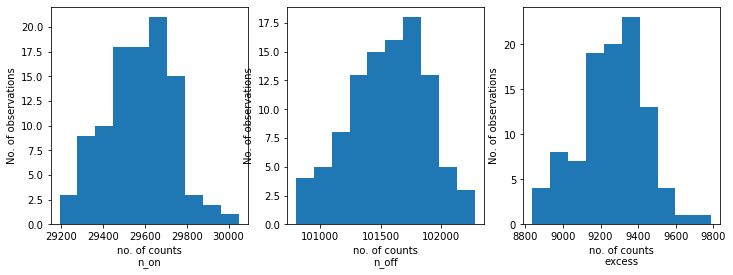

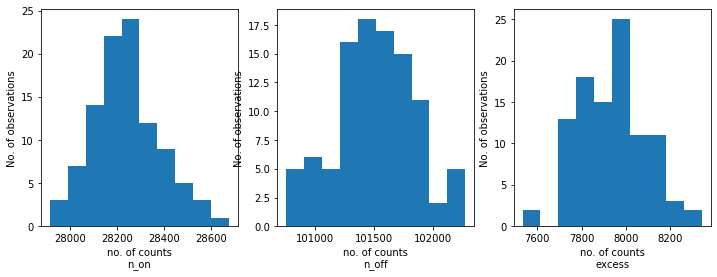

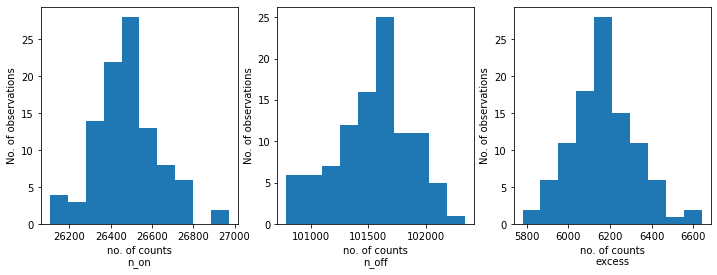

In [14]:
for i in range(10):
    n_on = [dataset.counts.data.sum() for dataset in datas[i]]
    n_off = [dataset.counts_off.data.sum() for dataset in datas[i]]
    excess = [dataset.excess.data.sum() for dataset in datas[i]]
    
    fix, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(n_on)
    axes[0].set_xlabel("no. of counts\nn_on")
    axes[0].set_ylabel("No. of observations")
    axes[1].hist(n_off)
    axes[1].set_xlabel("no. of counts\nn_off")
    axes[1].set_ylabel("No. of observations")
    axes[2].hist(excess)
    axes[2].set_xlabel("no. of counts\nexcess");
    axes[2].set_ylabel("No. of observations")

In [15]:
%%time
res = []
results = []
for dataset in datas[0]:
    dataset.models = model[0].copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
        }
    )
    print(result.parameters.to_table())
res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.287e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan

In [16]:
for i in range(9):
    results = []
    for dataset in datas[i+1]:
        dataset.models = model[i+1].copy()
        fit = Fit([dataset])
        result = fit.optimize()
        results.append(
            {
                "index": result.parameters["index"].value,
                "amplitude": result.parameters["amplitude"].value,
                "lambda_": result.parameters["lambda_"].value,
                "reference":result.parameters["reference"].value,
                "alpha":result.parameters["alpha"].value,
            }
        )
        print(result.parameters.to_table())
    res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.335e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.248e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.256e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.252e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.381e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.711e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.201e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.301e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.294e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.053e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.831e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.439e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.017e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.879e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.081e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.043e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.003e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.062e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.040e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.065e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.303e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.049e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.960e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.346e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.780e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.384e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.282e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.367e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.024e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.967e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.886e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.246e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.270e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.968e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.185e+00   nan                nan nan  False
amplitude 1.378e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.299e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.961e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.029e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.235e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.771e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.895e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.036e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.205e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.647e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.232e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.977e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.127e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.245e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.234e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.745e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.094e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.236e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.777e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.451e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.245e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.679e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.248e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.197e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.873e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.019e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.305e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.251e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.838e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.198e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.930e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.185e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.280e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.259e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.494e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.149e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.466e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.163e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.221e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.013e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.197e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.221e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.209e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.258e+00   nan                nan nan  False
amplitude 1.172e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.383e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.434e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.108e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.011e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.333e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.910e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.189e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.292e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.052e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.193e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.616e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.487e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.301e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.440e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.203e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.222e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.689e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.345e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.084e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.294e+00   nan                nan nan  False
amplitude 1.075e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.179e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.882e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.310e+00   nan                nan nan  False
amplitude 9.997e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.674e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.366e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.180e+00   nan                nan nan  False
amplitude 1.421e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.113e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.106e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.203e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.950e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.398e+00   nan                nan nan  False
amplitude 8.456e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.479e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.387e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.987e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.425e+00   nan                nan nan  False
amplitude 7.092e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.239e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.327e+00   nan                nan nan  False
amplitude 9.535e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.279e+00   nan                nan nan  False
amplitude 1.059e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.667e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.625e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.426e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.420e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.535e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.433e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.028e+00   nan                nan nan  False
amplitude 2.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.935e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.344e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.362e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.266e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.043e+00   nan                nan nan  False
amplitude 2.338e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.243e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.987e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.565e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.375e+00   nan                nan nan  False
amplitude 7.277e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.444e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.112e+00   nan                nan nan  False
amplitude 1.644e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.040e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.947e+00   nan                nan nan  False
amplitude 3.165e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.135e+00   nan                nan nan  False
amplitude 1.587e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.229e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.962e+00   nan                nan nan  False
amplitude 2.745e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.600e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.085e+00   nan                nan nan  False
amplitude 2.073e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.438e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.576e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.479e+00   nan                nan nan  False
amplitude 5.804e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.305e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.363e+00   nan                nan nan  False
amplitude 8.450e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.170e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.818e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.099e+00   nan                nan nan  False
amplitude 1.915e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.059e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.148e+00   nan                nan nan  False
amplitude 1.715e-12   nan cm-2 s-1 TeV-1 nan nan

In [17]:
import scipy.stats as stats
import math

In [18]:
index = []
amplitude = []
lambda_ = []
reference = []
alpha = []
covar = []
a = np.array([_["index"] for _ in res[0]])
b = np.array([_["amplitude"] for _ in res[0]])
c = np.array([_["reference"] for _ in res[0]])
index.append(a)
amplitude.append(b)
reference.append(c)
for i in range(9):
    a = np.array([_["index"] for _ in res[i+1]])
    b = np.array([_["amplitude"] for _ in res[i+1]])
    c = np.array([_["reference"] for _ in res[i+1]])
    d = np.array([_["lambda_"] for _ in res[i+1]])
    e = np.array([_["alpha"] for _ in res[i+1]])
    index.append(a)
    amplitude.append(b)
    reference.append(c)
    lambda_.append(d)
    alpha.append(e)
    
mu = [0,0,0,0,0,0,0,0,0,0]
sigma = [0,0,0,0,0,0,0,0,0,0]
np_hist = [0,0,0,0,0,0,0,0,0,0]
x = np.array([index[0], amplitude[0], reference[0]])
covar.append(np.cov(x))
for i in range(9):
    x = np.array([index[i+1], amplitude[i+1], reference[i+1], lambda_[i], alpha[i]])
    covar.append(np.cov(x))

index: 2.2204919365279925 += 0.006887393659463431
index: 2.220324070284429 += 0.009379018413887353
index: 2.220348181059343 += 0.012560505961135268
index: 2.2197998381733566 += 0.014822886565015363
index: 2.2206639900521976 += 0.018246261675460375
index: 2.2196131009666042 += 0.020581340802376027
index: 2.2170995413061525 += 0.03236781107873658
index: 2.2165125242333246 += 0.05146075528399513
index: 2.2188678764867964 += 0.07768259817585203
index: 2.192035678986916 += 0.1291685993704785


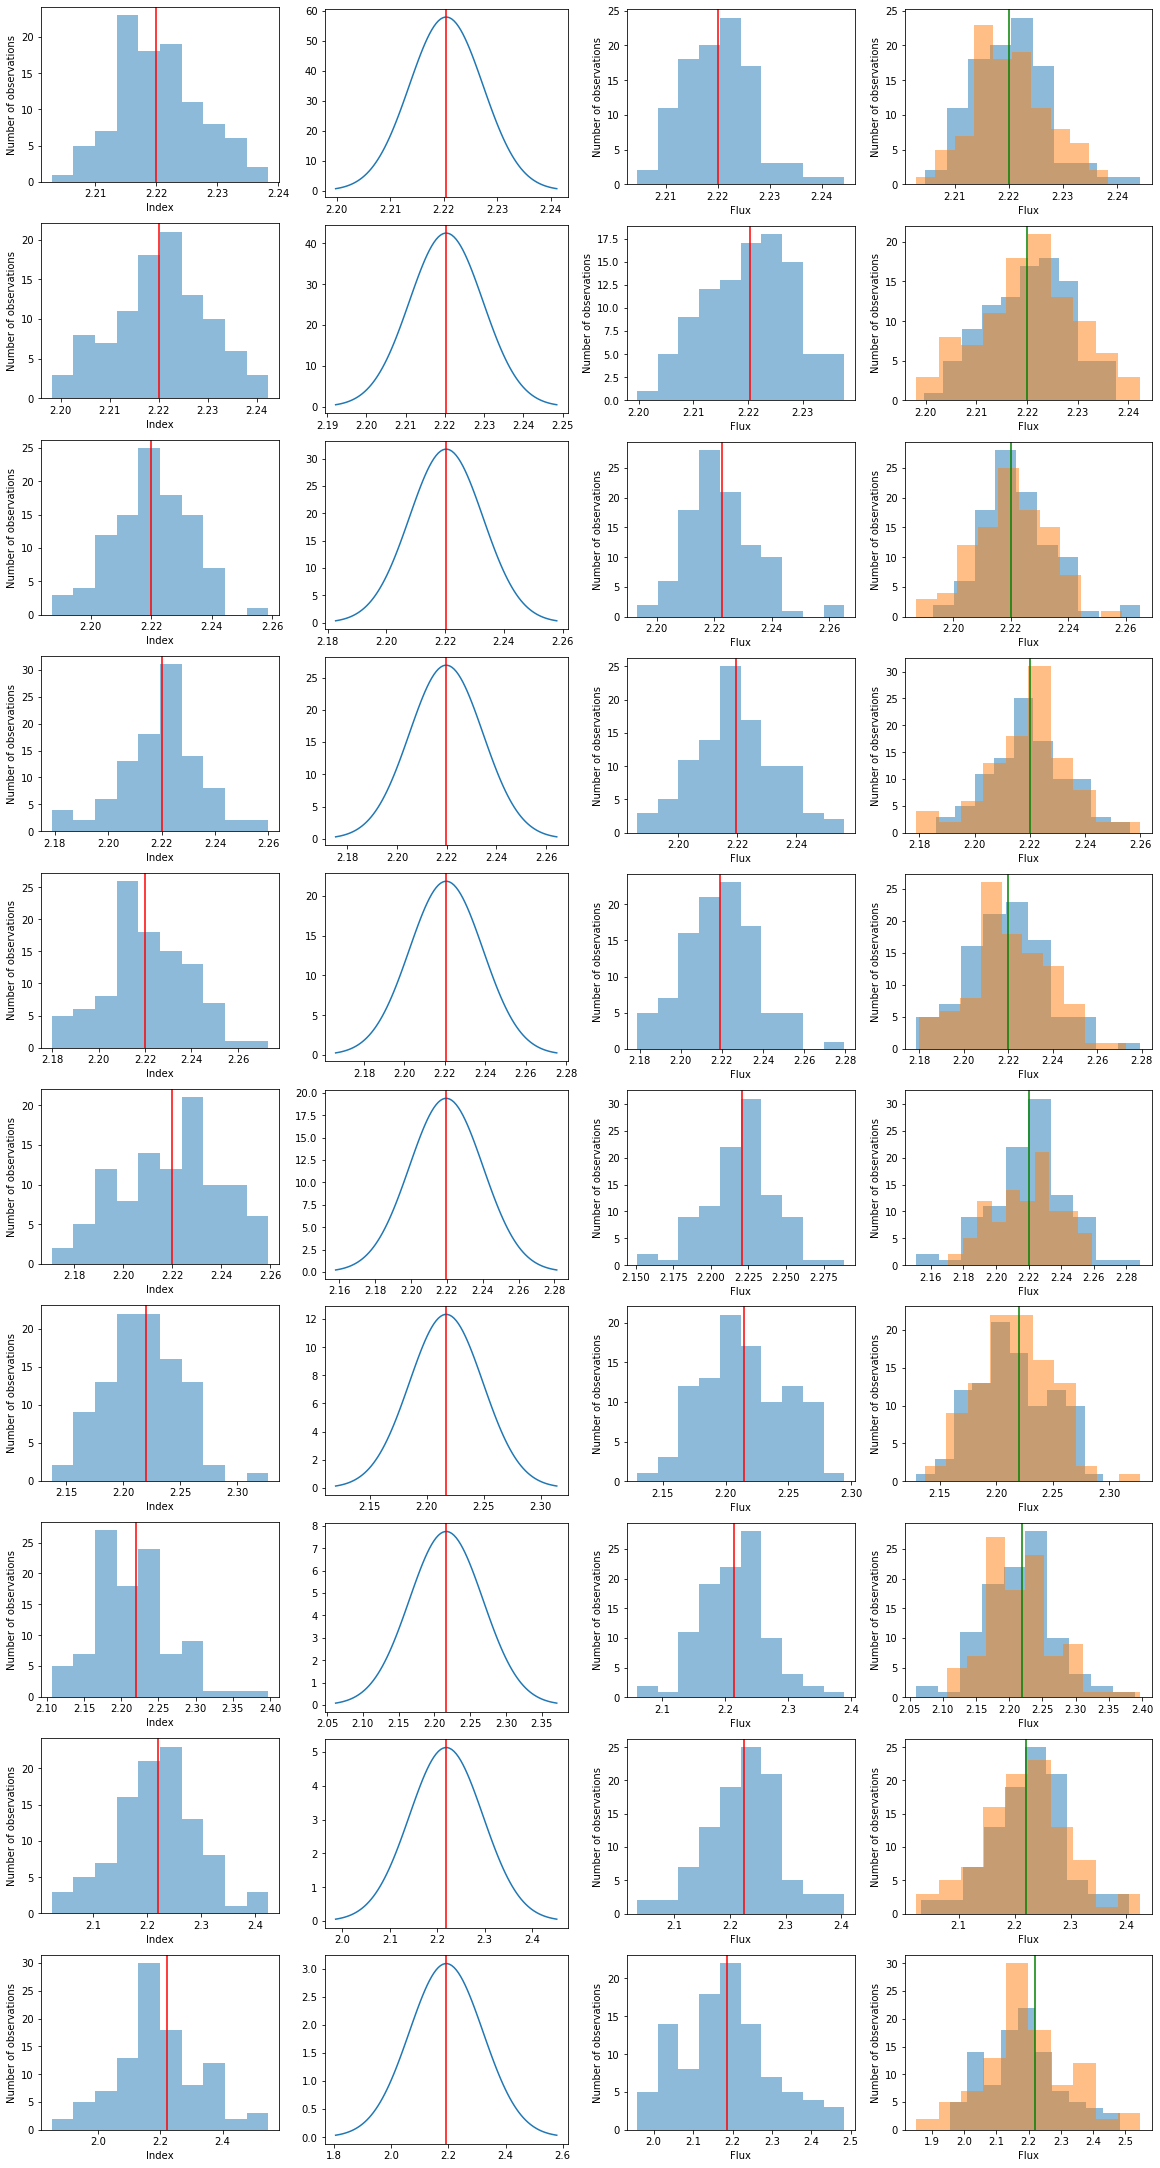

In [19]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n].mean()} += {index[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n+1].mean()} += {index[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = index[n].mean()
    sigma[n] = index[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

amplitude: 1.2882249390132875e-12 += 1.3619366125868166e-14
amplitude: 1.2885723616916947e-12 += 1.8508672332091317e-14
amplitude: 1.2891137688390412e-12 += 2.767892770007312e-14
amplitude: 1.2896103496159858e-12 += 3.6233239752501225e-14
amplitude: 1.2895908872469198e-12 += 4.779852196651729e-14
amplitude: 1.2902312616629744e-12 += 5.76960448438491e-14
amplitude: 1.2998066350226128e-12 += 1.008547298853344e-13
amplitude: 1.3166473609293271e-12 += 1.7753051144890234e-13
amplitude: 1.3279717012026768e-12 += 3.1291139238356374e-13
amplitude: 1.537971548065181e-12 += 6.75729761714786e-13


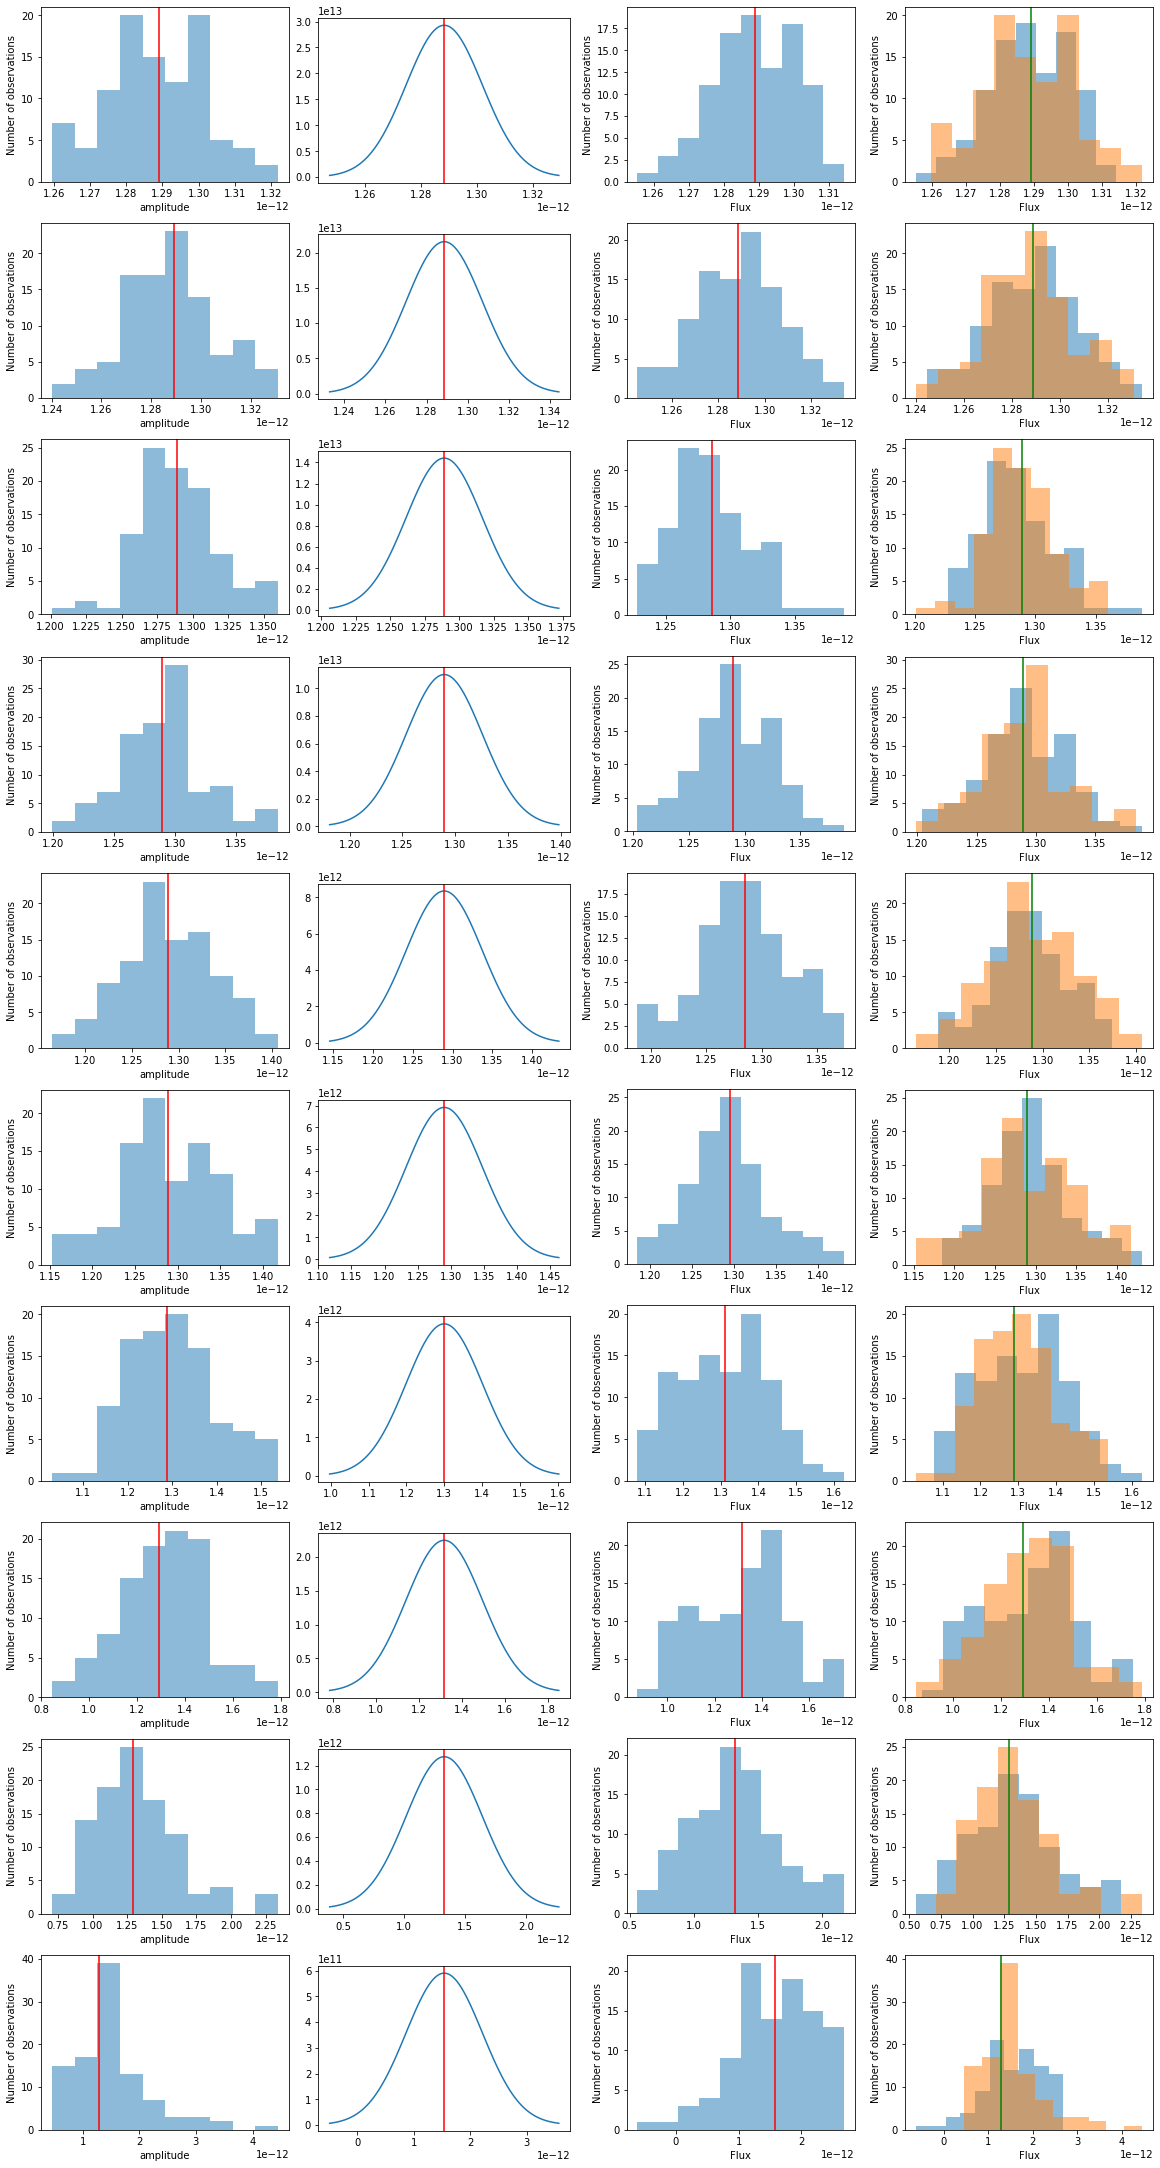

In [20]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n].mean()} += {amplitude[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n+1].mean()} += {amplitude[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = amplitude[n].mean()
    sigma[n] = amplitude[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

lambda_: 0.01009232190661445 += 0.0025347911631935886
lambda_: 0.10068133970197152 += 0.00845262529501963
lambda_: 0.2009203369977607 += 0.014587746767538996
lambda_: 0.30131438087122575 += 0.024272706337934807
lambda_: 0.5020272520100635 += 0.03598503233595532
lambda_: 1.0062518841404005 += 0.07687116798104435
lambda_: 2.027747879315675 += 0.19151314545308853
lambda_: 3.019060955047234 += 0.39064393678826664
lambda_: 5.226830558839477 += 0.9573838810767984


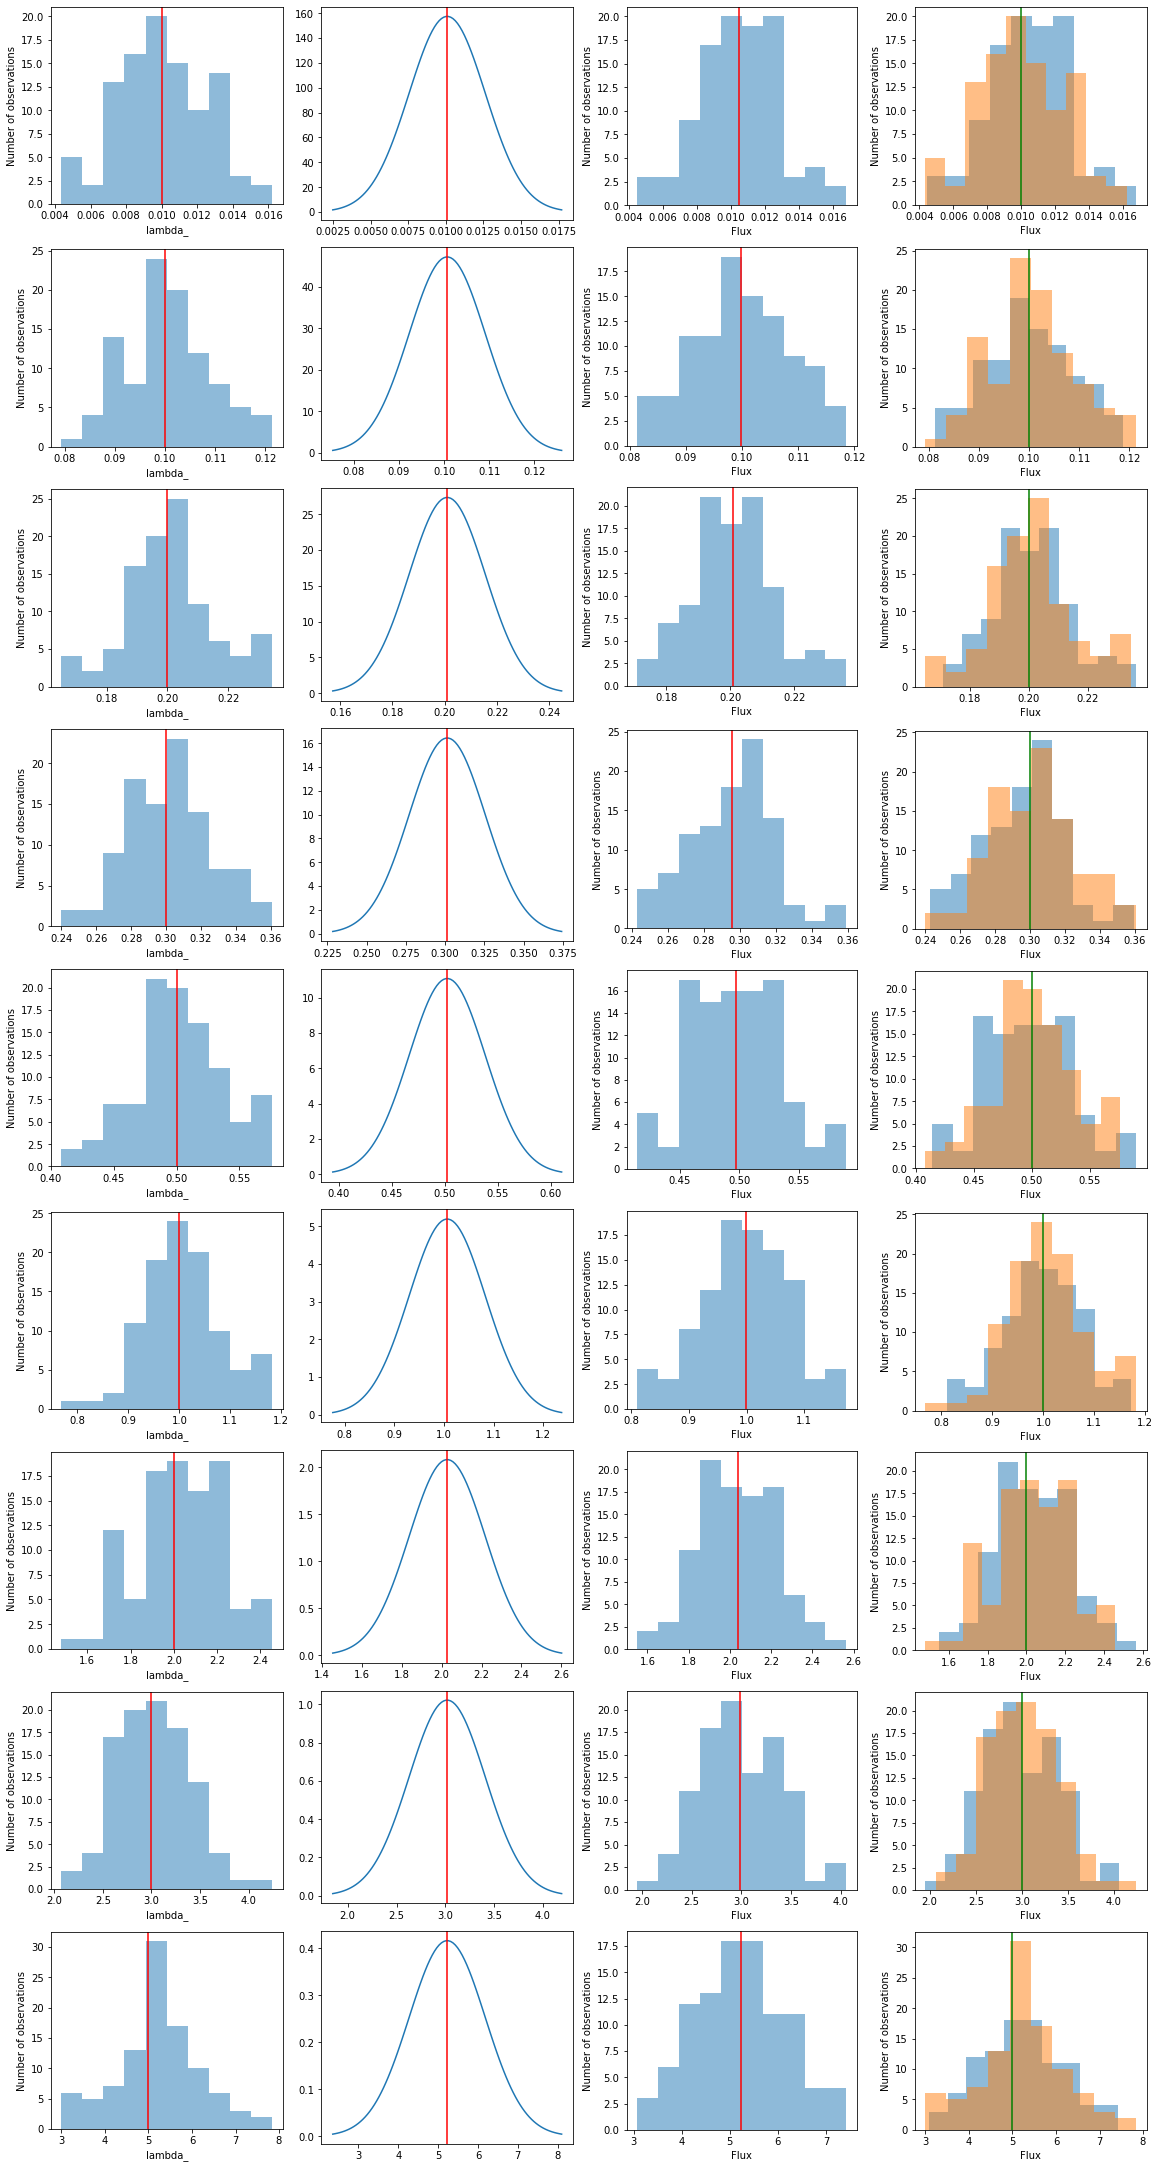

In [21]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[0])
for n in range(9):
    ax = fig.add_subplot(gs1[n])
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="red")
    plt.xlabel("lambda_")
    plt.ylabel("Number of observations")
    print(f"lambda_: {lambda_[n].mean()} += {lambda_[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[1])
for n in range(9):
    ax = fig.add_subplot(gs2[n])
    mu[n] = lambda_[n].mean()
    sigma[n] = lambda_[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[2])
for n in range(9):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[3])    
for n in range(9):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

In [22]:
sim = [] 
s = PowerLawSpectralModel(
    index=index[0].mean(),
    amplitude=amplitude[0].mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(s)
sim.append(s)

for i in range(9):
    s = ExpCutoffPowerLawSpectralModel(
        index=index[i+1].mean(),
        amplitude=amplitude[i+1].mean() * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=lambda_[i].mean() * u.Unit("TeV-1"),
        alpha = 1,
    )
    print(s)
    sim.append(s)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.009e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+

<function matplotlib.pyplot.show(*args, **kw)>

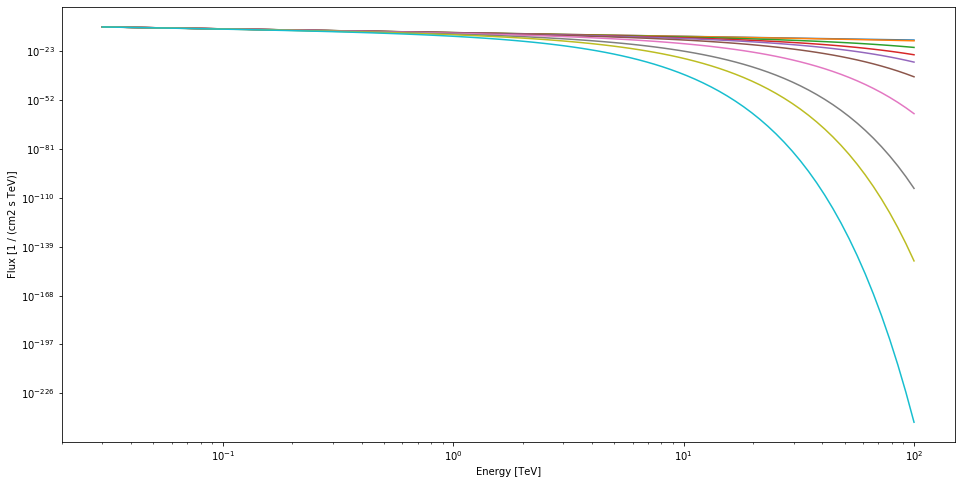

In [23]:
plt.figure(figsize=[16,8])
energy_range = [0.03, 100] * u.TeV
sim[0].plot(energy_range)
for i in range(9):
    sim[i+1].plot(energy_range)
plt.show

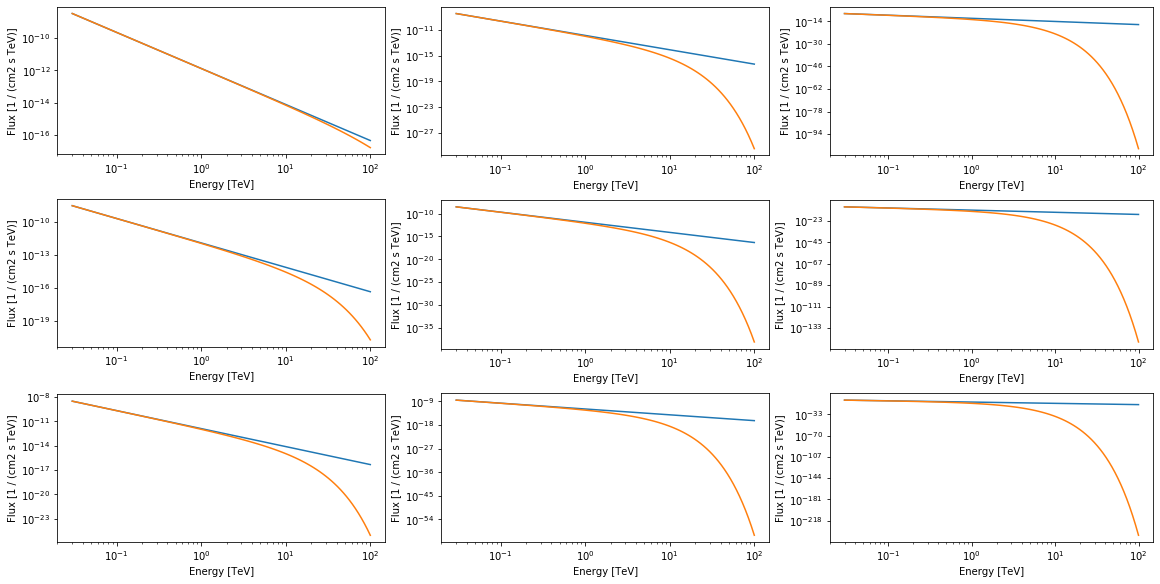

In [24]:
fig = plt.figure(figsize=[16,8],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range)
    sim[n+1].plot(energy_range)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range)
    sim[n+4].plot(energy_range)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range)
    sim[n+7].plot(energy_range)
    
plt.show()

In [25]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [26]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

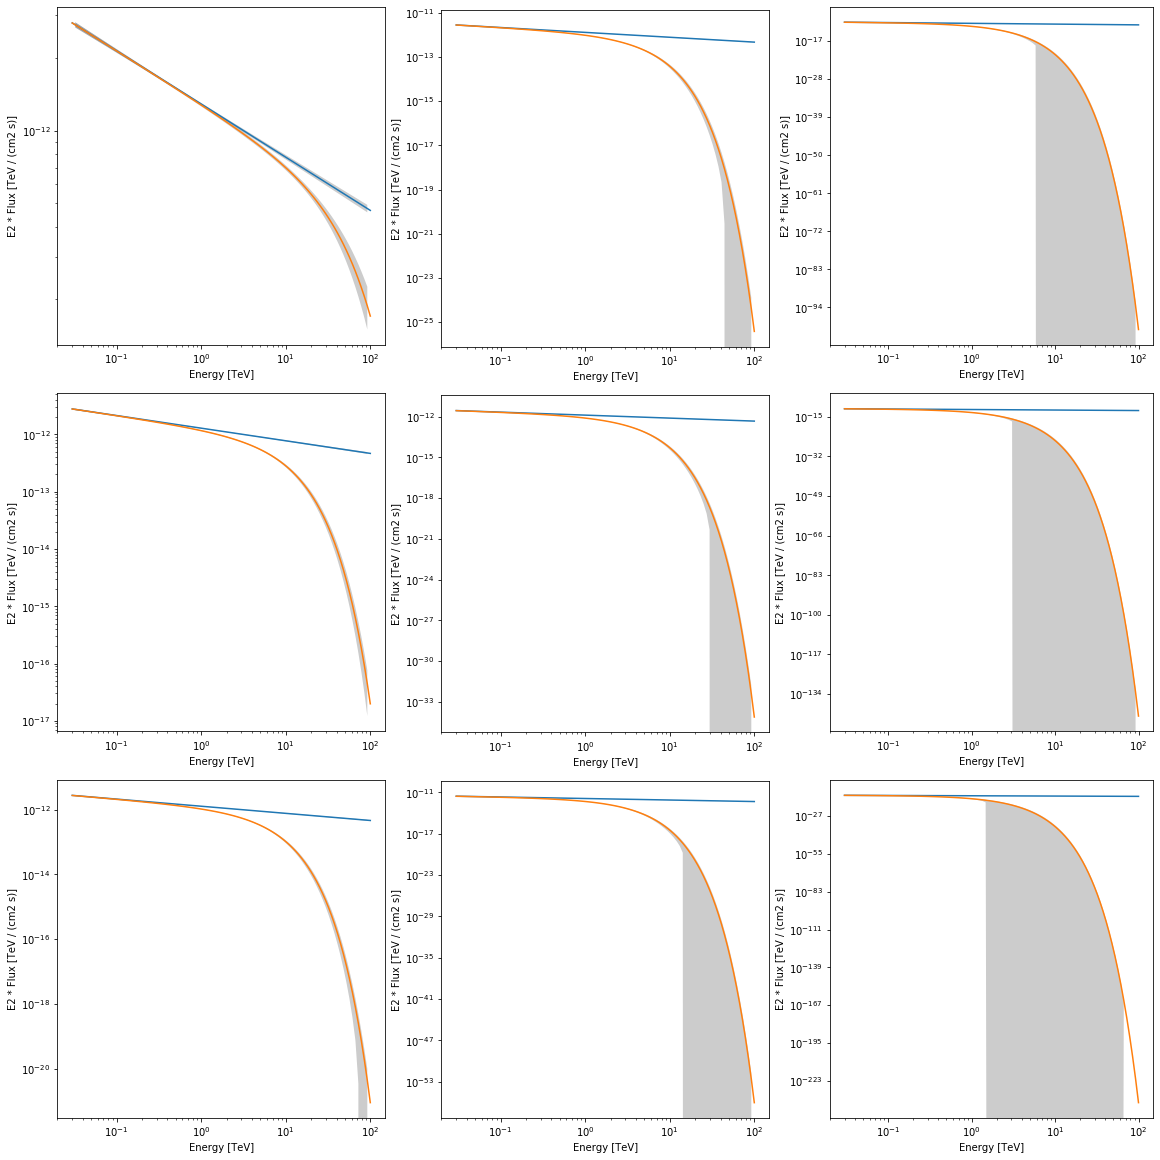

In [27]:
fig = plt.figure(figsize=[16,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+1].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+1], covar=covar[n+1],energy_range=energy_range, energy_power=2)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+4].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+4], covar=covar[n+4],energy_range=energy_range, energy_power=2)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+7].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+7], covar=covar[n+7],energy_range=energy_range, energy_power=2)
    
plt.show()